_Version log: Encouraging more exploration. Branch of V19._

In [6]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import fft as spfft
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether, the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $M$ and $\mathcal{F} (Y) = Y'$ as,
\begin{equation}
    ||M \times Y' - X||_{2} + \alpha ||Y'||_{1}.
\end{equation}

In [7]:
def open_compressed_dataset(file_name, file_type, compression):
    if file_type == ".csv":
        img = np.loadtxt("data\\" +file_name +file_type, delimiter=",")
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.

    return subsampled_points

In [8]:
file_name = "1dmock3"
file_type = ".csv"
compression = 1 #fraction of the dataset to keep

# original image
target, img = open_compressed_dataset(file_name, file_type, compression)
#target = target[200:801] #crop it
total_points = len(target)

In [9]:
iterations = 1000
max_temp = 50
cooling = 0.99
subsample_percentage = 0.05
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

reduced_points = round(total_points *subsample_percentage)
detectors = original_detectors = subsample_1d(total_points, subsample_percentage, "regular")

print(total_points, reduced_points)

320 16


In [10]:
scores = np.array([])
temps = []

result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
score = np.linalg.norm(target -result)

target_temp = max_temp
improvement = True
for n in tqdm(range(iterations)):

    #target_temp = max_temp *cooling**n +1

    if improvement: #Stop exploring and start optimising this regime.

        valid_vector_found = False
        while not valid_vector_found:
            temprature = target_temp
            random_vector = np.random.rand(reduced_points) -0.5
            random_vector /= np.linalg.norm(random_vector)
            random_step = random_vector *temprature
            new_detectors = np.round(detectors +random_step).astype(int)

            while 0 < temprature:
                bounds = np.concatenate([0 <= new_detectors, new_detectors < total_points, np.diff(new_detectors) > 0])
                if np.all(bounds):
                    valid_vector_found = True
                    break
                temprature -= 1
                random_step = random_vector *temprature
                new_detectors = np.round(detectors +random_step).astype(int)

        target_temp *= cooling

    else: #improvement == False. Trail has gone cold and we need to explore
        new_detectors = subsample_1d(total_points, subsample_percentage, "random")

    new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
    new_score = np.linalg.norm(target -new_result)

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors)]]

    if new_score < score:
        detectors = new_detectors
        result = new_result
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False

    scores = np.append(scores, score)

temps = np.array(temps).T

  1%|          | 6/1000 [00:00<00:17, 57.14it/s]

100%|██████████| 1000/1000 [00:15<00:00, 63.99it/s]


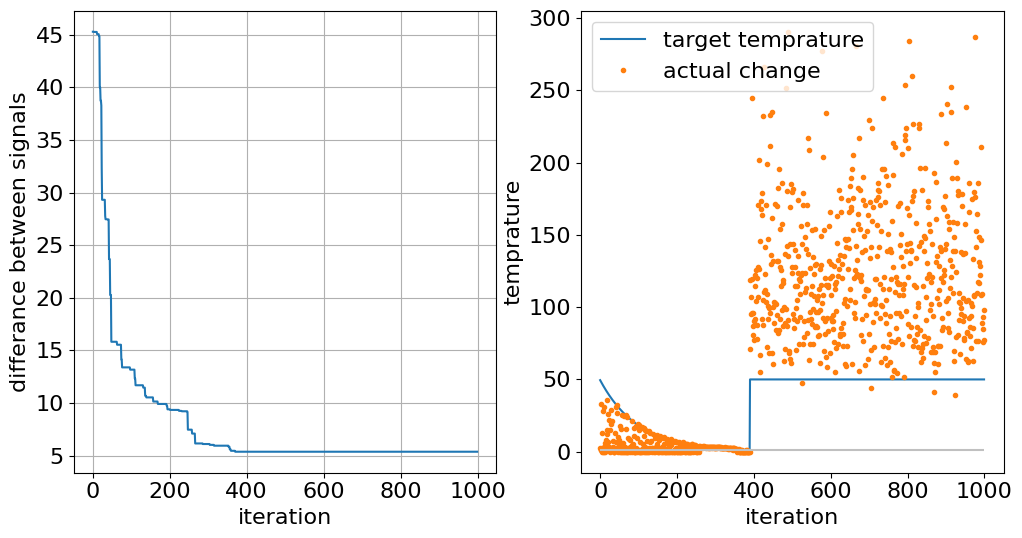

In [11]:
fig, axs = plt.subplots(1,2, figsize= (12,6))

axs[0].plot(scores) # Shows the convergnce as more detectors are added. (Why does it go back up? Do steeper slopes corrispond with better detector positions?)
axs[0].grid(True)
axs[0].set(ylabel= "differance between signals", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints. WHY IS THERE A PATTERN?? IT SHOULD BE RANDOM????
axs[1].hlines(1, 0, iterations, color= "silver")
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

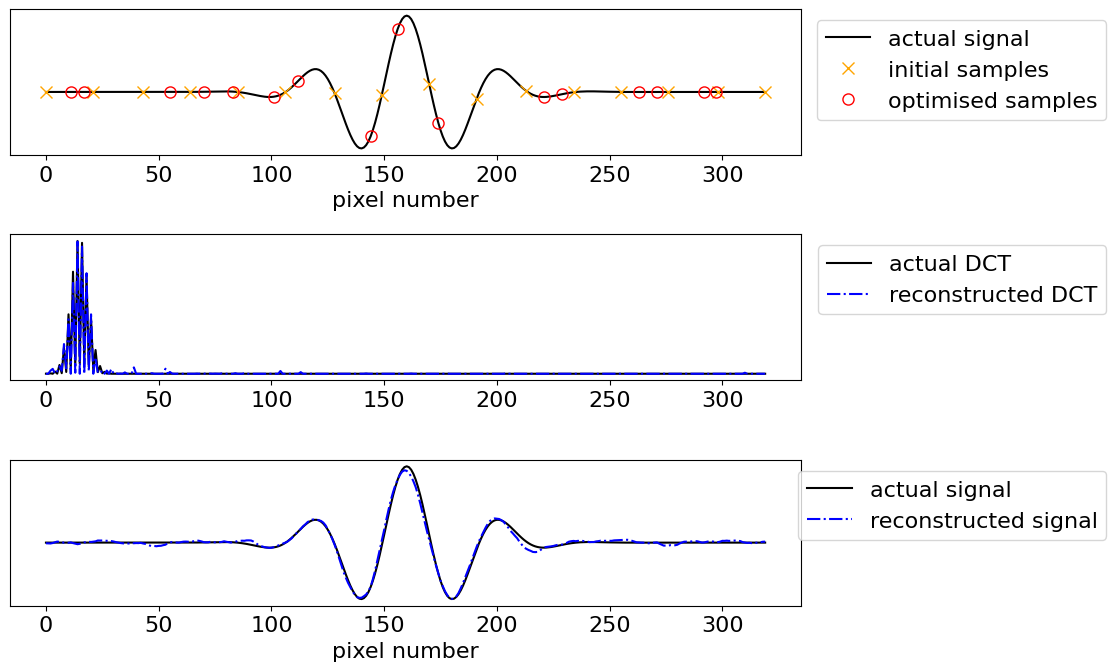

In [13]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(original_detectors, target[original_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()